<h1>Image Segmenation Model</h1>
<h2>Architecture Details</h2>
<p>Uses model pretrained on ImageNet dataset, loaded in via the <a href = "https://github.com/qubvel/segmentation_models/blob/master/examples/binary%20segmentation%20(camvid).ipynb">segmentation models</a> package. The model uses an efficientnetb1 architecture. Images were preprocessed used the segmentation model package as well.</p>
<p>
<h3>Hyperparameters</h3>
<p>The model was trained with the following hyperparameters:</p>
<ul>
    <li>All images were 512 x 512</li>
    <ul>
        <li>X values have 3 colors ways and are (512, 512, 3). Y values are grayscale and are (512, 512)</li>
    </ul>
    <li>Batch size = 12</li>
    <li>Epochs = 50</li>
    <ul>
        <li>With early stopping callback, where min_delta = 0.01 and patience = 5</li>
    </ul>
    <li>Learning rate = 1e-3</li>
    <li>Loss = binary focal loss</li>
    <ul>
        <li>focal loss was used because the majority of images are background (e.g. not an ad) and therefore there is a class imbalance</li>
</ul>

In [1]:
import os
import zipfile
import re
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib

import tensorflow as tf
import tensorflow.keras.backend as K
import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import cv2
import segmentation_models as sm
from segmentation_models.losses import BinaryFocalLoss

2023-04-18 21:52:43.869096: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Segmentation Models: using `keras` framework.


In [2]:
tf.config.run_functions_eagerly(True)

In [3]:
os.chdir("/home/haleyej/Data")

<h2>Load Data</h2>

In [4]:
X = os.listdir("JPEGImages")
Y = os.listdir("SegmentationClass")

In [5]:
X = pd.DataFrame(X, columns = ['x'])
Y = pd.DataFrame(Y, columns = ['y'])

In [6]:
user_num = r'\d{5}'
site_num = r'(\d{1,2}).png'

X['user'] = X.x.apply(lambda s: re.findall(user_num, s)[0])
Y['user'] = Y.y.apply(lambda s: re.findall(user_num, s)[0])

X['site'] = X.x.apply(lambda s: re.findall(site_num, s)[0])
Y['site'] = Y.y.apply(lambda s: re.findall(site_num, s)[0])

In [9]:
df = X.merge(Y, on = ['user', 'site'])

In [10]:
X_train, X_test_full, Y_train, Y_test_full = train_test_split(df.x, df.y, train_size = 0.70, test_size = 0.30, random_state = 42)
X_test, X_val, Y_test, Y_val = train_test_split(X_test_full, Y_test_full, train_size = 0.5, test_size = 0.5, random_state = 42)


<h2>Plotting Functions</h2>

In [11]:
def show_pred_mask(x, y, model, shape = (512, 512, 3)):
    '''
    Function to show real image, real mask 
    and predicted mask from ml model 
    
    ARGS:
        x = true image 
        y = true mask 
        model = segmentation model, used to create a predicted mask from the x value 
        shape = shape that predicted mask should have
        
    RETURNS:
        Returns none, cell will display plot
    '''
    fig, axes = plt.subplots(1, 3)

    pred = model.predict(tf.expand_dims(x, 0))
    pred = pred.reshape(shape[0], shape[1])

    axes[0].imshow(x, cmap = matplotlib.cm.Greys_r)
    axes[0].set_title('Actual Image')
    axes[0].axis('off')

    axes[1].imshow(y, cmap = matplotlib.cm.Greys_r)
    axes[1].set_title('Actual Mask')
    axes[1].axis('off')

    axes[2].imshow(pred, cmap = matplotlib.cm.Greys_r)
    axes[2].set_title('Predicted Mask')
    axes[2].axis('off')
  
    fig.show()


In [23]:
def plot_history(model_history, plot_file_title, path = "../Plots", save_plot = True):
    '''
    Takes in model history 
    Displays and saves plot of accuracy vs loss for each epoch
    Returns nothing
    
    ARGS:
        model_history = history, from model.fit
        plot_file_title = what to call saved plot
        path = path to save plot to 
        save_path = boolean, wether or not plot should be saved
        
    RETURNS:
        Returns none, cell will display plot
    '''
    epoch_range = range(len(model_history.history['accuracy']))
    
    training_loss = model_history.history['loss']
    training_accuracy = model_history.history['accuracy']

    val_loss = model_history.history['val_loss']  
    val_accuracy = model_history.history['val_accuracy']

    plt.plot(epoch_range, training_loss, '-b', label='training loss')
    plt.plot(epoch_range, training_accuracy, '-r', label='training accuracy')

    plt.plot(epoch_range, val_loss, '--b', label='validation loss')
    plt.plot(epoch_range, val_accuracy, '--r', label='validation accuracy')


    plt.title("Loss and Accuracy by Training Epoch")
    plt.xlabel("Epoch")
    plt.legend()
    if save_plot:
        plt.savefig(os.path.join(path, f"{plot_file_title}.png"))
    
    plt.show()


In [13]:
def get_predictions(x):
    '''
    Helper function (used with plot_roc_curve) to get
    prediction, where cells are a binary 1/0 
    (1 = ad, 0 = no an ad)
    
    ARGS:
        x = image to predict mask for 
        
    RETURNS:
        Returns predictions in unravelled form 
    '''
    pred = model.predict(np.array(x))
    pred = [(p[:, :] > 0.5).astype(float) for p in pred]
    return np.array(pred).ravel()

In [14]:
def plot_roc_curve(pred, true, plot_file_title, path = "../Plots", save_plot = True):
    '''
    Plots receiver operating characteristic curve 
    
    ARGS:
        pred = predicted pixel values
        true = true pixel values 
        plot_file_title = what to call saved plot
        path = path to save plot to 
        save_path = boolean, wether or not plot should be saved
        
    RETURNS:
        Returns none, cell will display plot 
    '''
    fpr, tpr, thresholds = roc_curve(true, pred)
    roc_auc = auc(fpr, tpr)
    
    fig, ax = plt.subplots(1,1)
    ax.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve')
    ax.legend(loc="lower right")
    
    if save_plot:
        plt.savefig(os.path.join(path, f"{plot_file_title}.png"))
    
    plt.show()

In [15]:
def dice_coef(y_true, y_pred, smooth = 10):  
    '''
    Function to calculate dice coefficent, which 
    is the similarity between two samples
    
    ARGS:
        y_true = true mask 
        y_pred = predicted_mask
        smooth = used to prevent 0 division errors when y_pred 
                 and y_true don't have any foreground pixels 
                 
    RETURNS:
        dice coefficent value. the dice coefficient will always 
        be between 0 and 1, where values closer to 1 means that 
        y_true and y_pred are more similar
    '''
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_loss(y_true, y_pred, smooth = 100):
    '''
    Calls dice_coef function, returns 
    1 - dice_coef to make the function 
    minimizable for loss 
    
    ARGS:
        y_true = true mask 
        y_pred = predicted_mask
        smooth = used to prevent 0 division errors when y_pred 
                 and y_true don't have any foreground pixels 
                 
    RETURNS:
        1 - dice coefficent. Values should always be between 0, 1. 
        Since a dice coefficient near 1 means two samples are very similar, 
        we want dice_loss to return a small number
    '''
    return 1 - dice_coef(y_true, y_pred, smooth)

<h2>Segmentation Model</h2>

In [16]:
BACKBONE = 'efficientnetb1'
LEARNING_RATE = 1e-3


model = sm.Unet(BACKBONE, classes = 1, input_shape = (512, 512, 3))
preprocess_input = sm.get_preprocessing(BACKBONE)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
              loss = BinaryFocalLoss(), 
              metrics = ['accuracy', dice_coef]
             )

2023-04-18 21:52:51.938134: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 21:52:51.940831: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


<p>Open and reshape image files</p>

In [17]:
x_path = os.path.join(os.getcwd(), 'JPEGImages')
y_path = os.path.join(os.getcwd(), 'SegmentationClass')

SHAPE = (512, 512)

X_train_arrays = [cv2.resize(cv2.imread(os.path.join(x_path, x)), SHAPE) for x in X_train]
Y_train_arrays = [cv2.resize(cv2.imread(os.path.join(y_path, y), cv2.IMREAD_GRAYSCALE), SHAPE) for y in Y_train]

X_test_arrays = [cv2.resize(cv2.imread(os.path.join(x_path, x)), SHAPE) for x in X_test]
Y_test_arrays = [cv2.resize(cv2.imread(os.path.join(y_path, y), cv2.IMREAD_GRAYSCALE), SHAPE) for y in Y_test]

X_val_arrays = [cv2.resize(cv2.imread(os.path.join(x_path, x)), SHAPE) for x in X_val]
Y_val_arrays = [cv2.resize(cv2.imread(os.path.join(y_path, y), cv2.IMREAD_GRAYSCALE), SHAPE) for y in Y_val]

<p>Preprocess images, ensure all values in mask are 0/1</p>

In [18]:
X_train_arrays = [preprocess_input(x) for x in X_train_arrays]
Y_train_arrays = [preprocess_input(y) for y in Y_train_arrays]
Y_train_arrays = [(y[:, :] != 0).astype(float) for y in Y_train_arrays]

X_test_arrays = [preprocess_input(x) for x in X_test_arrays]
Y_test_arrays = [preprocess_input(y) for y in Y_test_arrays]
Y_test_arrays = [(y[:, :] != 0).astype(float) for y in Y_test_arrays]

X_val_arrays = [preprocess_input(x) for x in X_val_arrays]
Y_val_arrays = [preprocess_input(y) for y in Y_val_arrays]
Y_val_arrays = [(y[:, :] != 0).astype(float) for y in Y_val_arrays]

In [19]:
SAVE_PATH = '../Weights/v17_pretrained'

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 5, restore_best_weights = False)
model_checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath = SAVE_PATH, monitor = 'val_loss', save_best_only = True, mode = 'min')



In [20]:
EPOCHS = 50
BATCH_SIZE = 12

model_history = model.fit(np.array(X_train_arrays), np.array(Y_train_arrays), epochs = EPOCHS, batch_size = BATCH_SIZE, 
                          callbacks = [model_checkpoints],  
                          validation_data = (np.array(X_val_arrays), np.array(Y_val_arrays)))


Epoch 1/50


/home/haleyej/miniconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 [==============================] - ETA: 0s - loss: 0.0306 - accuracy: 0.8814 - dice_coef: 0.3238 

INFO:tensorflow:Assets written to: ../Weights/v17_pretrained/assets


INFO:tensorflow:Assets written to: ../Weights/v17_pretrained/assets


65/65 [==============================] - 1037s 16s/step - loss: 0.0306 - accuracy: 0.8814 - dice_coef: 0.3238 - val_loss: 0.2552 - val_accuracy: 0.8868 - val_dice_coef: 0.6630
Epoch 2/50
65/65 [==============================] - ETA: 0s - loss: 0.0182 - accuracy: 0.9292 - dice_coef: 0.4425 

INFO:tensorflow:Assets written to: ../Weights/v17_pretrained/assets


INFO:tensorflow:Assets written to: ../Weights/v17_pretrained/assets


65/65 [==============================] - 987s 15s/step - loss: 0.0182 - accuracy: 0.9292 - dice_coef: 0.4425 - val_loss: 0.0531 - val_accuracy: 0.9307 - val_dice_coef: 0.5773
Epoch 3/50
65/65 [==============================] - ETA: 0s - loss: 0.0129 - accuracy: 0.9506 - dice_coef: 0.5197 

INFO:tensorflow:Assets written to: ../Weights/v17_pretrained/assets


INFO:tensorflow:Assets written to: ../Weights/v17_pretrained/assets


65/65 [==============================] - 962s 15s/step - loss: 0.0129 - accuracy: 0.9506 - dice_coef: 0.5197 - val_loss: 0.0209 - val_accuracy: 0.9502 - val_dice_coef: 0.5510
Epoch 4/50
65/65 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 0.9535 - dice_coef: 0.5568 

INFO:tensorflow:Assets written to: ../Weights/v17_pretrained/assets


INFO:tensorflow:Assets written to: ../Weights/v17_pretrained/assets


65/65 [==============================] - 957s 15s/step - loss: 0.0117 - accuracy: 0.9535 - dice_coef: 0.5568 - val_loss: 0.0143 - val_accuracy: 0.9437 - val_dice_coef: 0.5327
Epoch 5/50
65/65 [==============================] - ETA: 0s - loss: 0.0096 - accuracy: 0.9636 - dice_coef: 0.5927 

INFO:tensorflow:Assets written to: ../Weights/v17_pretrained/assets


INFO:tensorflow:Assets written to: ../Weights/v17_pretrained/assets


65/65 [==============================] - 931s 14s/step - loss: 0.0096 - accuracy: 0.9636 - dice_coef: 0.5927 - val_loss: 0.0139 - val_accuracy: 0.9491 - val_dice_coef: 0.5471
Epoch 6/50
65/65 [==============================] - 820s 13s/step - loss: 0.0073 - accuracy: 0.9718 - dice_coef: 0.6413 - val_loss: 0.0149 - val_accuracy: 0.9495 - val_dice_coef: 0.6147
Epoch 7/50
65/65 [==============================] - 813s 13s/step - loss: 0.0071 - accuracy: 0.9714 - dice_coef: 0.6677 - val_loss: 0.0232 - val_accuracy: 0.9611 - val_dice_coef: 0.7171
Epoch 8/50
65/65 [==============================] - 802s 12s/step - loss: 0.0061 - accuracy: 0.9760 - dice_coef: 0.6876 - val_loss: 0.0188 - val_accuracy: 0.9591 - val_dice_coef: 0.7291
Epoch 9/50
65/65 [==============================] - 842s 13s/step - loss: 0.0072 - accuracy: 0.9725 - dice_coef: 0.6818 - val_loss: 0.0141 - val_accuracy: 0.9509 - val_dice_coef: 0.5657
Epoch 10/50
65/65 [==============================] - 873s 13s/step - loss: 0.0071

INFO:tensorflow:Assets written to: ../Weights/v17_pretrained/assets


INFO:tensorflow:Assets written to: ../Weights/v17_pretrained/assets


65/65 [==============================] - 931s 14s/step - loss: 0.0043 - accuracy: 0.9834 - dice_coef: 0.7504 - val_loss: 0.0132 - val_accuracy: 0.9679 - val_dice_coef: 0.7254
Epoch 16/50
65/65 [==============================] - 829s 13s/step - loss: 0.0032 - accuracy: 0.9872 - dice_coef: 0.7739 - val_loss: 0.0155 - val_accuracy: 0.9638 - val_dice_coef: 0.7347
Epoch 17/50
65/65 [==============================] - 900s 14s/step - loss: 0.0031 - accuracy: 0.9884 - dice_coef: 0.7925 - val_loss: 0.0171 - val_accuracy: 0.9646 - val_dice_coef: 0.7431
Epoch 18/50
65/65 [==============================] - 834s 13s/step - loss: 0.0027 - accuracy: 0.9897 - dice_coef: 0.8030 - val_loss: 0.0160 - val_accuracy: 0.9634 - val_dice_coef: 0.7412
Epoch 19/50
65/65 [==============================] - 840s 13s/step - loss: 0.0028 - accuracy: 0.9895 - dice_coef: 0.8129 - val_loss: 0.0209 - val_accuracy: 0.9599 - val_dice_coef: 0.6901
Epoch 20/50
65/65 [==============================] - 843s 13s/step - loss: 0.

INFO:tensorflow:Assets written to: ../Weights/v17_pretrained/assets


INFO:tensorflow:Assets written to: ../Weights/v17_pretrained/assets


65/65 [==============================] - 950s 15s/step - loss: 0.0031 - accuracy: 0.9882 - dice_coef: 0.7813 - val_loss: 0.0121 - val_accuracy: 0.9702 - val_dice_coef: 0.7290
Epoch 34/50
65/65 [==============================] - 822s 13s/step - loss: 0.0020 - accuracy: 0.9924 - dice_coef: 0.8254 - val_loss: 0.0181 - val_accuracy: 0.9636 - val_dice_coef: 0.7330
Epoch 35/50
65/65 [==============================] - 815s 13s/step - loss: 0.0025 - accuracy: 0.9912 - dice_coef: 0.8242 - val_loss: 0.0296 - val_accuracy: 0.9648 - val_dice_coef: 0.7398
Epoch 36/50
65/65 [==============================] - 815s 13s/step - loss: 0.0024 - accuracy: 0.9908 - dice_coef: 0.8272 - val_loss: 0.0178 - val_accuracy: 0.9692 - val_dice_coef: 0.7837
Epoch 37/50
65/65 [==============================] - 815s 13s/step - loss: 0.0018 - accuracy: 0.9931 - dice_coef: 0.8471 - val_loss: 0.0153 - val_accuracy: 0.9655 - val_dice_coef: 0.7460
Epoch 38/50
65/65 [==============================] - 805s 12s/step - loss: 0.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



65/65 [==============================] - 865s 13s/step - loss: 0.0035 - accuracy: 0.9869 - dice_coef: 0.8001 - val_loss: 0.0488 - val_accuracy: 0.9403 - val_dice_coef: 0.7178
Epoch 49/50
65/65 [==============================] - 809s 12s/step - loss: 0.0043 - accuracy: 0.9839 - dice_coef: 0.7656 - val_loss: 0.0214 - val_accuracy: 0.9630 - val_dice_coef: 0.7708
Epoch 50/50
65/65 [==============================] - 787s 12s/step - loss: 0.0028 - accuracy: 0.9897 - dice_coef: 0.8061 - val_loss: 0.0167 - val_accuracy: 0.9653 - val_dice_coef: 0.7304


In [ ]:
#model.load_weights(SAVE_PATH).expect_partial()

In [22]:
Y_test_pred = model.evaluate(np.array(X_test_arrays), np.array(Y_test_arrays))

/home/haleyej/miniconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


6/6 [==============================] - 37s 6s/step - loss: 0.0140 - accuracy: 0.9640 - dice_coef: 0.7624


<h3>Visualize model results</h3>

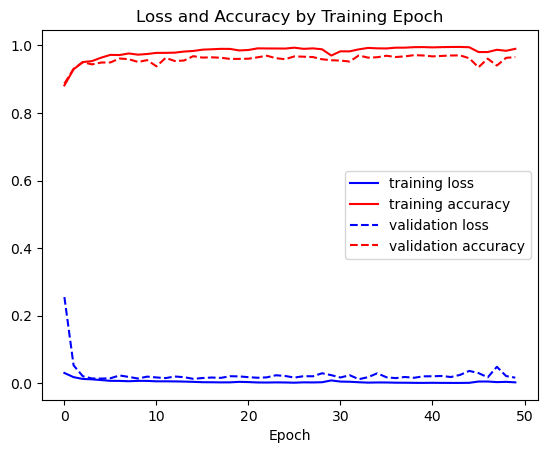

In [24]:
plot_history(model_history, 'prototype_plot_16_pretrained')

6/6 [==============================] - 36s 6s/step


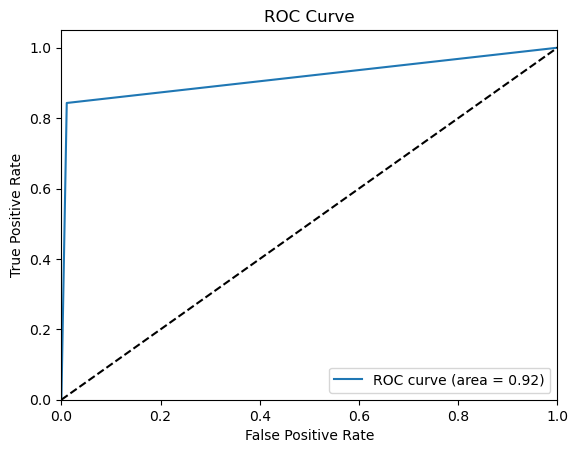

In [25]:
pred = get_predictions(X_test_arrays)
plot_roc_curve(pred, np.array(Y_test_arrays).ravel(), 'roc_curve_16', path = "../Plots")

1/1 [==============================] - 1s 853ms/step


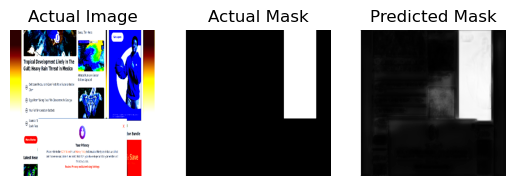

In [30]:
show_pred_mask(X_test_arrays[4], Y_test_arrays[4], model)

<h2>Save Masks</h2>

In [58]:
def save_masks(arrays, img_list, mask_save_path = "../Data/predicted_masks", shape = SHAPE):
    '''
    Takes in a list of image arrays, gets 
    predicted mask and saves them
    
    ARGS:
        arrays = list of arrays to get masks for 
        img_list = list or Pandas series with the file 
                   names of the original image 
        mask_save_path = path to save segmentation masks to
        shape = shape of segmenation masks
        
    RETURNS:
        Returns none, saves masks to mask_save_path 
        directory
    '''
    user_num_regex = r'\d{5}'
    site_num_regex = r'(\d{1,2}).png'

    for i in range(len(arrays)):
        pred = model.predict(tf.expand_dims(arrays[i], 0))
        pred = pred.reshape(shape[0], shape[1])
        
        if type(img_list) == list:
            img = img_list[i]
        elif type(img_list) == pd.core.series.Series:
            img = img_list.iloc[i]
        
        user_num = re.findall(user_num_regex, img)[0]
        site_num = re.findall(site_num_regex, img)[0]
        
        plt.imsave(os.path.join(mask_save_path, f"user_{user_num}_{site_num}.png"), pred, cmap = 'Greys')

In [59]:
save_masks(X_test_arrays, X_test)

1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 2s 2s/step


In [60]:
save_masks(X_train_arrays, X_train)

1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 1s 913ms/step


1/1 [==============================] - 1s 759ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


In [61]:
save_masks(X_val_arrays, X_val)

1/1 [==============================] - 1s 774ms/step


1/1 [==============================] - 1s 1s/step
